# REGCOIL-Like Coil Optimization in DESC

This notebook will show how to use DESC's REGCOIL implementation to find coils using the surface current optimization method, based off of [1]. We will find a coilset for the precise QA equilibrium by first finding a constant offset winding surface, then running the REGCOIL algorithm in two different ways to obtain the surface current which minimizes the quadratic flux on the plasma surface, and finally cutting that surface current into coils and checking the normal field error and field line tracing from that coilset to confirm the equilibrium surfaces are retained with the real coil field.

## REGCOIL Algorithm

The REGCOIL algorithm solves the following minimization problem

Follows algorithm of [1]_ to find the current potential Phi on the surface, given a surface current $\mathbf{K}$ from a surface current potential $\Phi$ on a winding surface:
$$\mathbf{K} =\mathbf{n} \times  \nabla \Phi $$
$$\Phi(\theta',\zeta') = \Phi_{sv}(\theta',\zeta') + \frac{G\zeta'}{2\pi} + \frac{I\theta'}{2\pi}$$
where the single valued part is given as a double Fourier series in the poloidal and toroidal angles:

$$\Phi_{SV}(\theta,\zeta) = \sum_{m,n} \Phi_{SV}^{mn} \mathcal{G}^{m}_{n}(\theta,\zeta)$$

where

$$
   \mathcal{G}^{m}_{n}(\theta,\zeta) = \begin{cases}
   \cos(|m|\theta)\cos(|n|N_{FP}\zeta) &\text{for }m\ge0, n\ge0 \\[.2cm]
   \cos(|m|\theta)\sin(|n|N_{FP}\zeta) &\text{for }m\ge0, n<0 \\[.2cm]
   \sin(|m|\theta)\cos(|n|N_{FP}\zeta) &\text{for }m<0, n\ge0 \\[.2cm]
   \sin(|m|\theta)\sin(|n|N_{FP}\zeta) &\text{for }m<0, n<0.
   \end{cases}
$$


The algorithm minimizes the quadratic flux on the plasma surface due to the
surface current and external fields:

$$\min_{\Phi_{SV}^{mn}} ~\chi^2_B + \lambda_regularization \chi^2_K$$

where $\mathbf{B}\cdot\mathbf{n} = B_n$ and $\mathbf{n}$ is the unit surface normal on the plasma surface $S_{plasma}$, while 

$$\chi^2_B = \int_{S_{plasma}} (B_n)^2 dA$$

is the quadratic flux on the plasma boundary from the total magnetic field:

$$B_n = B_n^{SV}\{\Phi_{SV}\} + B_n^{GI} +B_n^{plasma} + B_n^{ext}$$

where the individual contributions to the normal field are the field from the single-valued surface current potential $B_n^{SV}$, the field from the secular part of the surface current potential $B_n^{GI}$, the field from the plasma currents $B_n^{plasma}$ and then any external fields $B_n^{ext}$ (e.g. a TF coilset or other coilset besides the winding surface). $G$ is fixed by the equilibrium magnetic field strength, and $I$ is determined by the desired coil topology (given by the `current_helicity` tuple in the `run_regcoil` method below), with `current_helicity = (q,p)`. If `q` is nonzero and `p` is zero, it corresponds to modular coils, and non-zero `q` and `p` corresponds to helical coils, according to the formula $I = -\frac{p*G}{ N_{FP} *q})$. The problem is regularized by the addition of a regularization parameter $\lambda_regularization$ multiplying the surface current magnitude integrated over the winding surface $S_{winding}$:

$$\chi^2_K = \int_{S_{winding}} |\mathbf{K}|^2 dA'$$

Smaller lambda_regularization corresponds to no regularization (consequently, lower Bn error but more complex and large surface currents) and larger lambda_regularization corresponds to more regularization (consequently, higher Bn error but simpler and smaller surface currents), which we will show shortly in this notebook.

[1] Landreman, An improved current potential method for fast computation of stellarator coil shapes, Nuclear Fusion (2017)

In [1]:
# imports
from desc import set_device
# set_device("gpu")
# uncomment above line if you are running on a GPU for a big speedup!
import numpy as np

from desc.equilibrium import  Equilibrium
from desc.geometry import FourierRZToroidalSurface
from desc.grid import LinearGrid
from desc.io import load
from desc.objectives import (
    FixParameters,
    ObjectiveFunction,
    QuadraticFlux,
    SurfaceCurrentRegularization
)
from desc.optimize import Optimizer
from scipy.constants import mu_0
from desc.magnetic_fields import FourierCurrentPotentialField, run_regcoil

from desc.examples import get
from desc.plotting import plot_comparison, plot_regcoil_outputs, plot_surfaces, plot_3d, plot_coils, plot_2d, poincare_plot

DESC version 0.12.1+443.gff65cbe94.dirty,using JAX backend, jax version=0.4.30, jaxlib version=0.4.30, dtype=float64
Using device: CPU, with 2.84 GB available memory


In [2]:
# define utility function
def plot_field_lines(field, eq):
    # for starting locations we'll pick positions on flux surfaces on the outboard midplane
    grid_trace = LinearGrid(rho=np.linspace(0, 1, 9))
    r0 = eq.compute("R", grid=grid_trace)["R"]
    z0 = eq.compute("Z", grid=grid_trace)["Z"]
    fig, ax =plot_surfaces(eq)
    fig, ax = poincare_plot(
        field,
        r0,
        z0,
        NFP=eq.NFP,
        ax=ax,
        color="k",
        size=1,
    )
    return fig, ax

## Create Constant Offset Surface

We will use the algorithm outlined in the appendix of [1] to create a surface offset from the precise QA equilibrium surface by a constant distance of 0.2 meters. In DESC this is implemented as the `constant_offset_surface` method of `FourierRZToroidalSurface`, which will create a constant offset surface from the surface object it is called with by fitting a surface to points offset along the unit surface normal evaluated at a given grid on the base surface. We can thus use `eq.surface.constant_offset_surface(offset)` to obtain the desired surface.

In [3]:
eq = get("precise_QA")

# create the constant offset surface
surf = eq.surface.constant_offset_surface(offset=0.25, # desired offset
                                          M=16, # Poloidal resolution of desired offset surface
                                          N=16, # Toroidal resolution of desired offset surface
                                          grid=LinearGrid(M=32,N=32,NFP=eq.NFP)) # grid of points on base surface to evaluate unit normal and find points on offset surface,
                                                                                 # generally should be twice the desired resolution


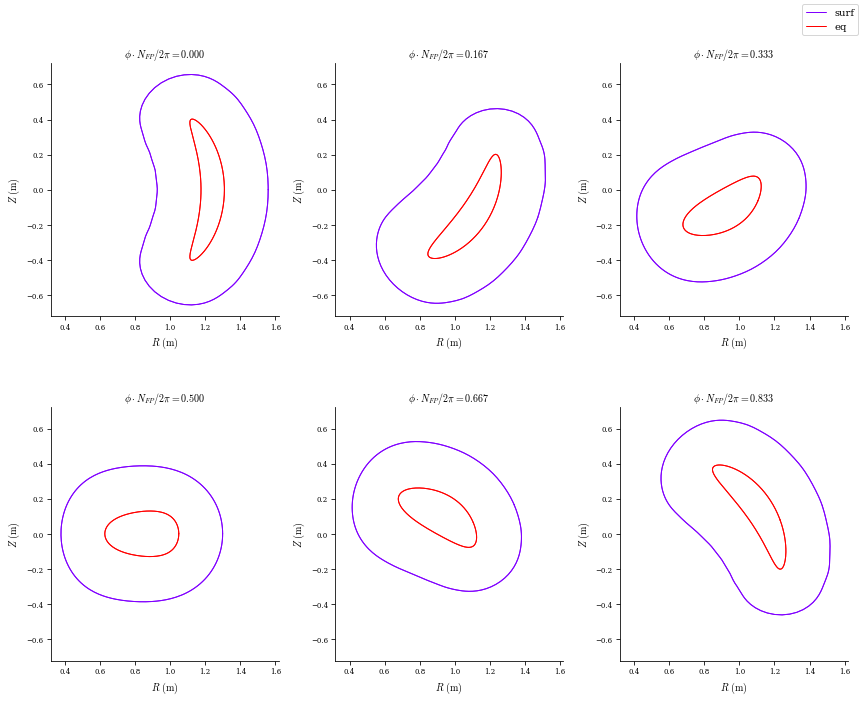

In [4]:
plot_comparison([surf,eq],labels=["surf","eq"],theta=0,rho=np.array(1.0));

## REGCOIL Algorithm through `SurfaceCurrentField.run_regcoil` Method

To run the REGCOIL algorithm outlined earlier in this notebook, we can use the `FourierCurrentPotentialField` object in DESC, which describes a magnetic field created from a surface current of the form used in REGCOIL:
$$\mathbf{K} =\mathbf{n} \times  \nabla \Phi $$
$$\Phi(\theta',\zeta') = \Phi_{sv}(\theta',\zeta') + \frac{G\zeta'}{2\pi} + \frac{I\theta'}{2\pi}$$

where `FourierCurrentPotentialField.Phi_mn` corresponds to the Fourier coefficients of $\Phi_{sv}$, and `FourierCurrentPotentialField.I` and `FourierCurrentPotentialField.G` correspond to the net toroidal current on the surface $I$ and the net poloidal current on the surface $G$. $G$ is determined by the desired equilibrium field strength, and is manually assigned in this cell for clarity (in practice the `run_regcoil` method will automatically assign `G` according to the equilibrium field strength). We will show both modular $I=0$ and helical $I\neq0$ coils in this notebook.

### Modular

#########################################################
Calculating Phi_SV forlambda_regularization = 0.00000e+00
#########################################################
chi^2 B = 6.31929e-16
min Bnormal = 6.80874e-13 (unitless)
Max Bnormal = 3.13282e-08 (unitless)
Avg Bnormal = 3.95086e-09 (unitless)
#########################################################
Calculating Phi_SV forlambda_regularization = 1.00000e-30
#########################################################
chi^2 B = 6.31929e-16
min Bnormal = 6.80869e-13 (unitless)
Max Bnormal = 3.13282e-08 (unitless)
Avg Bnormal = 3.95086e-09 (unitless)
#########################################################
Calculating Phi_SV forlambda_regularization = 1.00000e-29
#########################################################
chi^2 B = 6.31929e-16
min Bnormal = 6.80826e-13 (unitless)
Max Bnormal = 3.13282e-08 (unitless)
Avg Bnormal = 3.95086e-09 (unitless)
#########################################################
Calculating Phi_SV fo

({'fig_chi^2_B_vs_lambda_regularization': <Figure size 1152.86x864.648 with 1 Axes>,
  'fig_chi^2_K_vs_lambda_regularization': <Figure size 1152.86x864.648 with 1 Axes>,
  'fig_chi^2_B_vs_chi^2_K': <Figure size 1152.86x864.648 with 1 Axes>,
  'fig_scan_Phi': <Figure size 1152.86x864.648 with 32 Axes>,
  'fig_scan_Bn': <Figure size 1152.86x864.648 with 32 Axes>,
  'fig_scan_K': <Figure size 1152.86x864.648 with 32 Axes>},
 {'ax_chi^2_B_vs_lambda_regularization': <Axes: xlabel='$\\lambda$ (regularization parameter)', ylabel='$\\chi^2_B = \\int \\int B_{normal}^2 dA$ '>,
  'ax_chi^2_K_vs_lambda_regularization': <Axes: xlabel='$\\lambda$ (regularization parameter)', ylabel="$\\chi^2_K = \\int \\int K^2 dA'$ ">,
  'ax_chi^2_B_vs_chi^2_K': <Axes: xlabel="$\\chi^2_K = \\int \\int K^2 dA'$ ", ylabel='$\\chi^2_B = \\int \\int B_{normal}^2 dA$ '>,
  'ax_scan_Phi': <Axes: title={'center': 'lambda= 1.00000e-01 index = 30'}, xlabel='zeta', ylabel='theta'>,
  'ax_scan_Bn': <Axes: title={'center': 'l

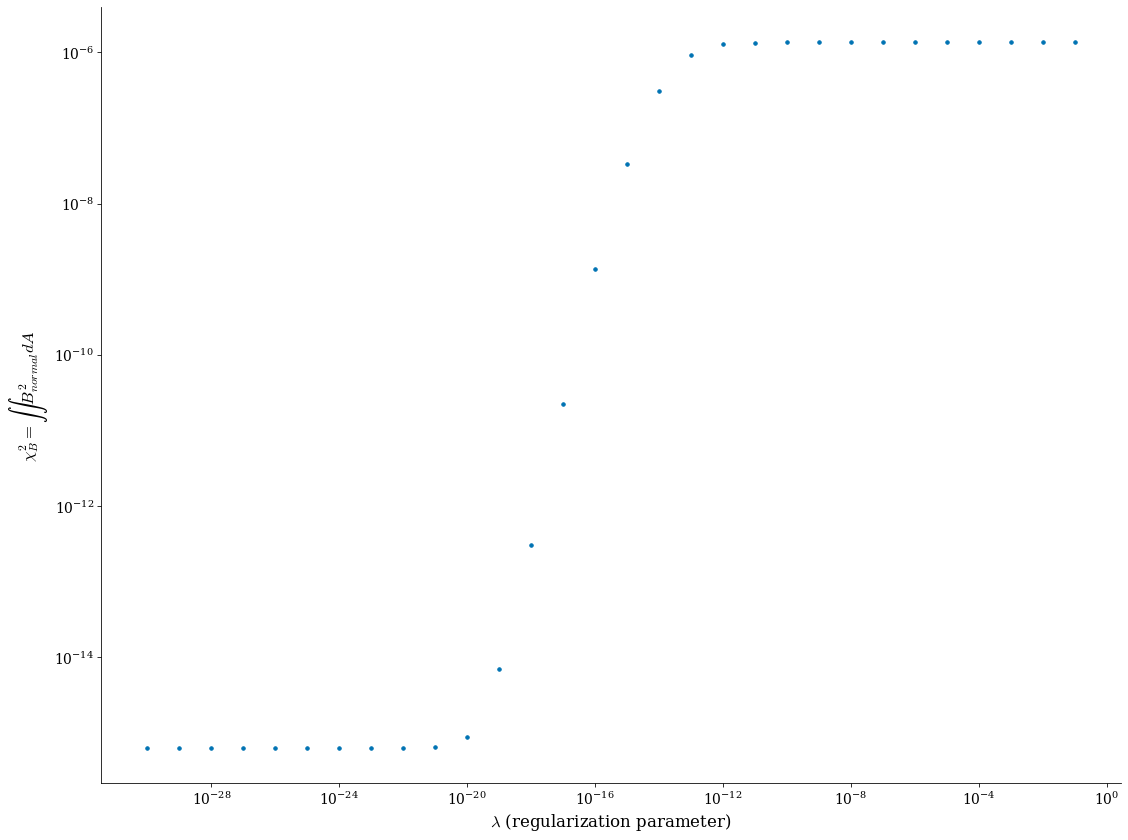

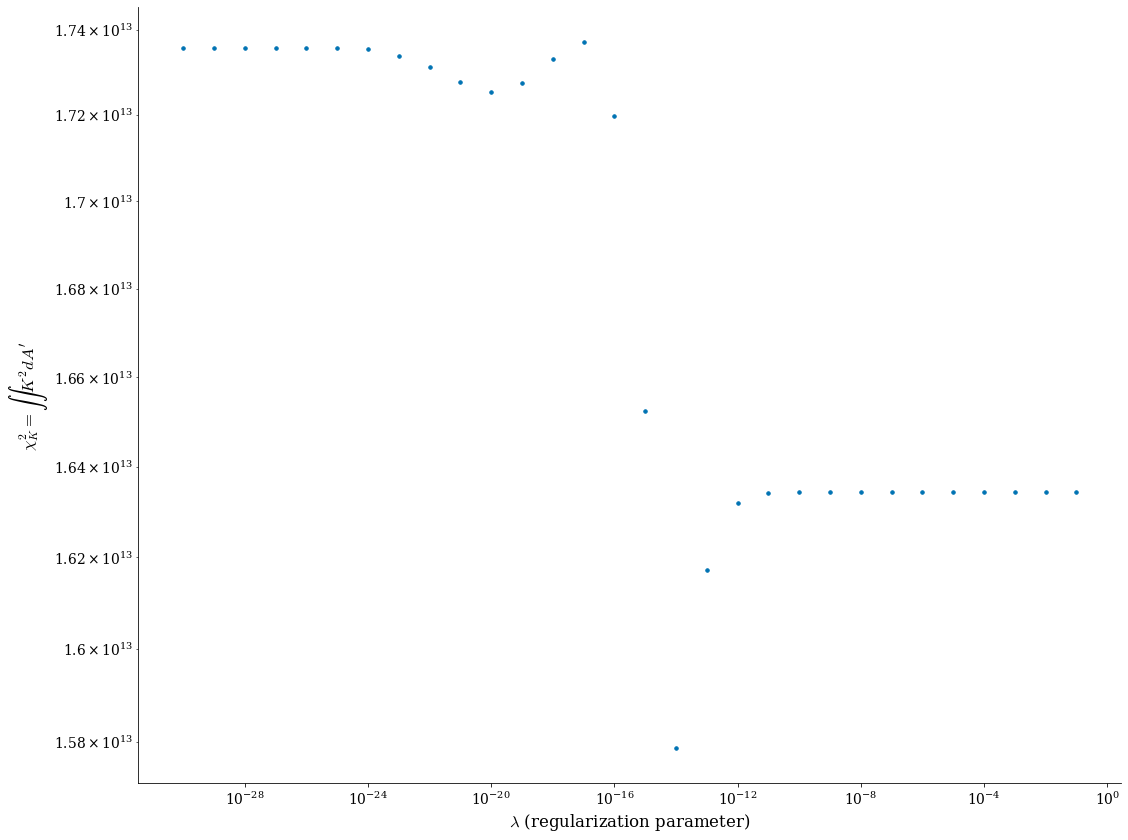

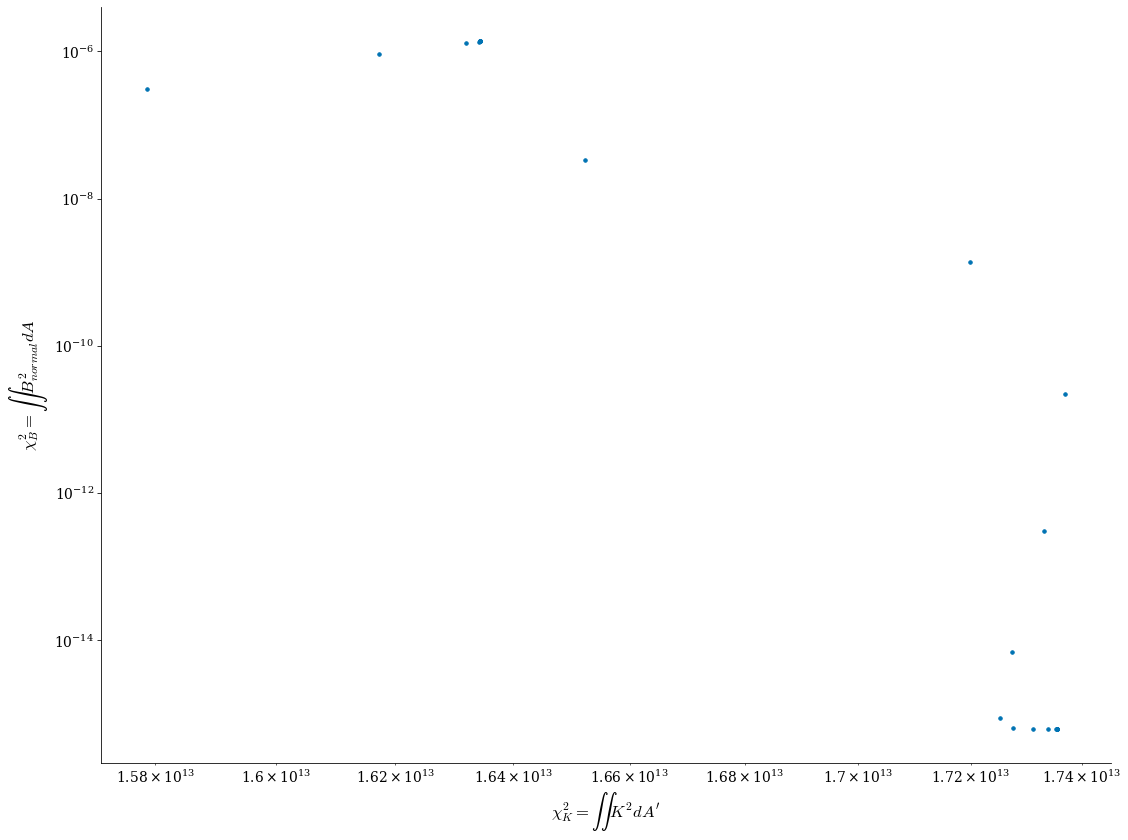

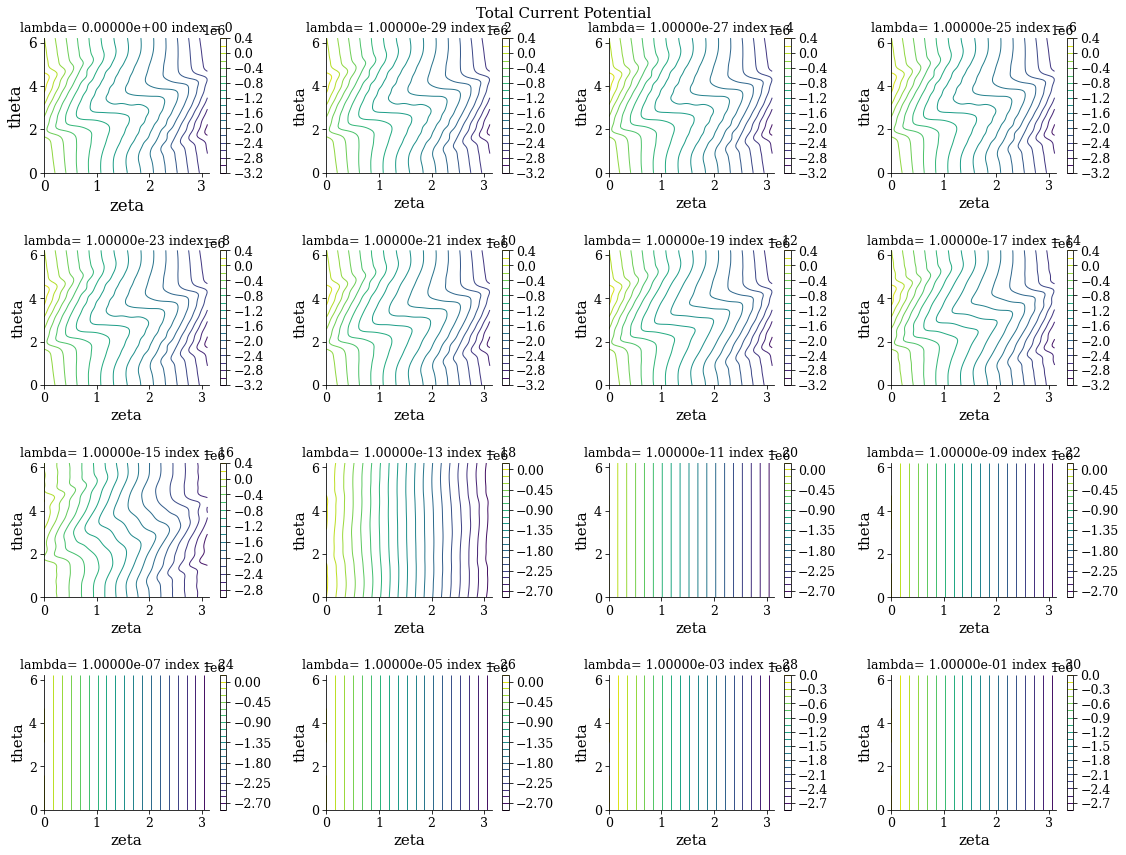

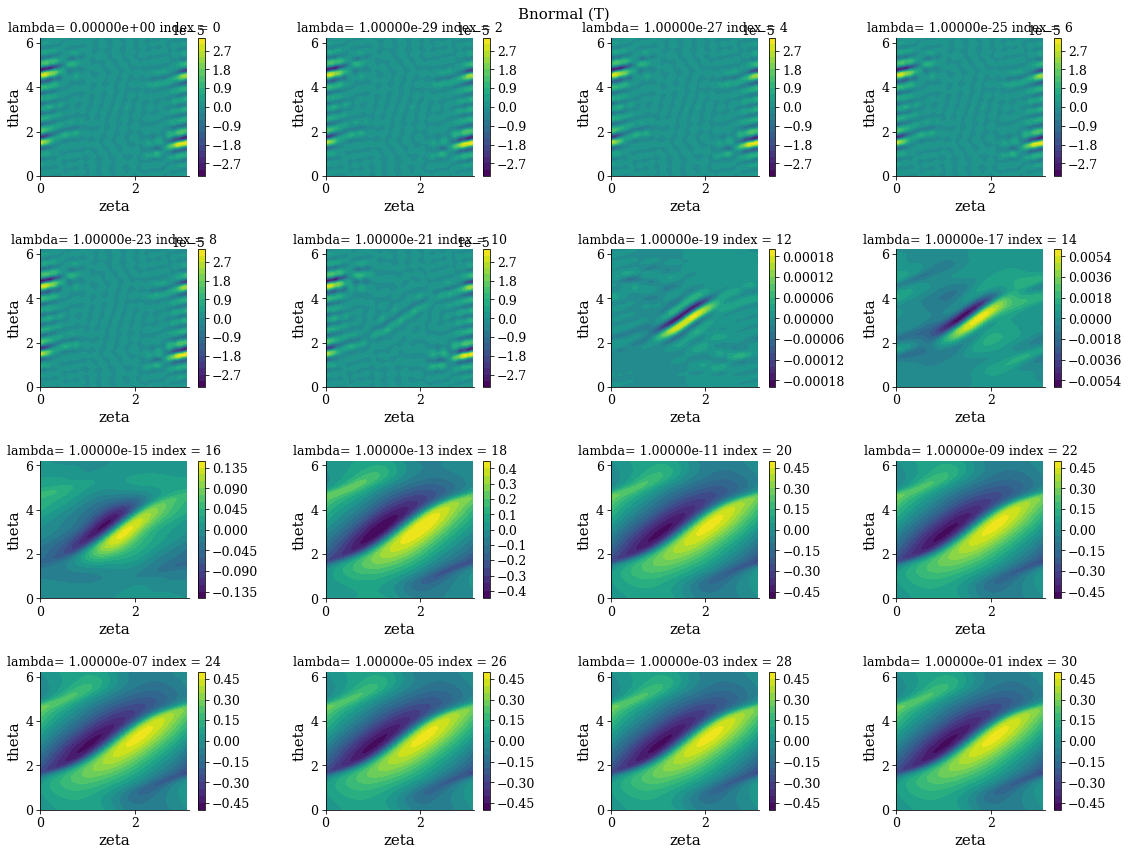

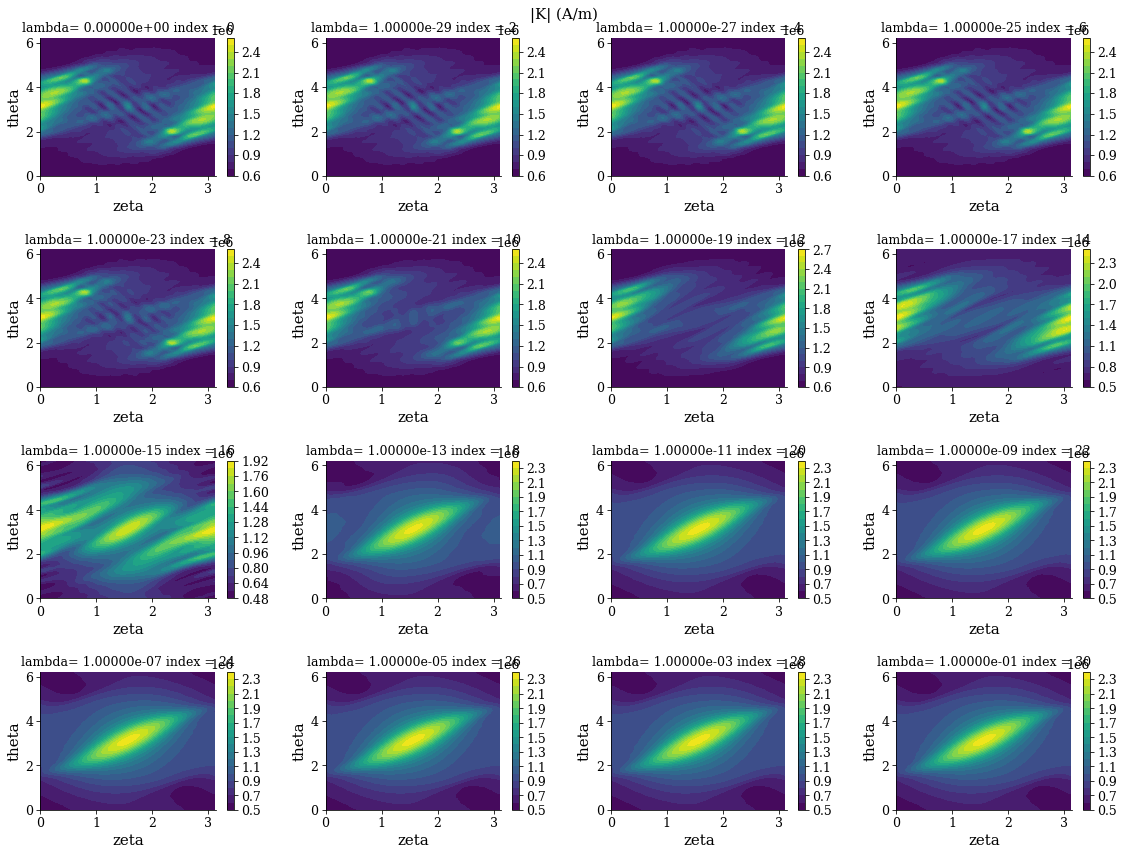

In [5]:
# create the FourierCurrentPotentialField object from the constant offset surface we found in the previous cell
surface_current_field = FourierCurrentPotentialField.from_surface(surf,
                                                                  I=0,
                                                                  # manually setting G to value needed to provide the equilibrium's toroidal flux,
                                                                  # though this is not necessary as it gets set automatically inside the run_regcoil function
                                                                  G=np.asarray([-eq.compute("G", grid=LinearGrid(rho=np.array(1.0)))["G"][0] / mu_0 * 2 * np.pi]), 
                                                                  # set symmetry of the current potential, "sin" is usually expected for stellarator-symmetric surfaces and equilibria
                                                                  sym_Phi="sin",)

surface_current_field.change_Phi_resolution(M=12,N=12)

# create the evaluation grid (where Bn will be minimized on plasma surface)
# and source grid (discretizes the source K for biot-savart and where |K| will be penalized on winding surface)
Megrid=45
Negrid=45
Msgrid=45
Nsgrid=45

eval_grid=LinearGrid(M=Megrid,N=Negrid,NFP=eq.NFP,sym=True)
# ensure that sym=False for source grid so the field evaluated from the surface current is accurate
# (i.e. must evalute source over whole surface, not just the symmetric part)
# NFP>1 is ok, as we internally will rotate the source through the field periods to sample entire winding surface
sgrid=LinearGrid(M=Msgrid,N=Nsgrid,NFP=eq.NFP,sym=False) 

lambda_regularization = np.append(np.array([0]),np.logspace(-30,-1,30))

# run_regcoil method runs the REGCOIL algorithm
fields,data = run_regcoil(surface_current_field, # the surface current field whose geometry and Phi resolution will be used
                                         eq=eq, # the Equilibrium object to minimize Bn on the surface of
                                         source_grid=sgrid, # source grid
                                         eval_grid=eval_grid, # evaluation grid
                                         current_helicity=(1,0), # pair of integers (q,p), determines topology of contours (similar to QS helicity),
                                         #  q is the poloidal frequency of the transits per field period (the number of times the coil transits poloidally over a single field period)
                                         # and p is the toroidal analog (if q!=0 and p=0, we have modular coils, if both q and p are nonzero, we have helical coils)
                                         lambda_regularization=lambda_regularization, # we pass in an array to perform scan over the regularization parameter (which we call lambda_regularization) to see tradeoff between Bn and current complexity
                                         # lambda_regularization can also be just a single number in which case no scan is performed
                                         vacuum=True, # this is a vacuum equilibrium, so no need to calculate the Bn contribution from the plasma currents
                                         )
surface_current_field = fields[0] # fields is a list of FourierCurrentPotentialField objects
# the plot function can take either the list or a single field, all that matters is it has
# the correct Phi resolution and surface geometry
plot_regcoil_outputs(surface_current_field, data, eq,vacuum=True)

`data` is a dictionary containing the `Phi_mn` arrays for each different value of $\lambda_regularization$ (corresponding to the `data["lambda_regularizations"]` item in the dict), as well as other useful information like the net currents $I$ and $G$ and the cost functions $\chi^2_B$ and $\chi^2_K$ at each value of $\lambda_regularization$

In [6]:
data.keys()

dict_keys(['eval_grid', 'source_grid', 'lambda_regularization', 'Phi_mn', 'I', 'G', 'chi^2_B', 'chi^2_K', '|K|', 'Bn_total'])

### Helical

#########################################################
Calculating Phi_SV forlambda_regularization = 0.00000e+00
#########################################################
chi^2 B = 4.03460e-13
min Bnormal = 5.98364e-13 (unitless)
Max Bnormal = 6.44035e-07 (unitless)
Avg Bnormal = 1.19003e-07 (unitless)
#########################################################
Calculating Phi_SV forlambda_regularization = 1.00000e-30
#########################################################
chi^2 B = 4.03460e-13
min Bnormal = 5.98364e-13 (unitless)
Max Bnormal = 6.44035e-07 (unitless)
Avg Bnormal = 1.19003e-07 (unitless)
#########################################################
Calculating Phi_SV forlambda_regularization = 1.00000e-29
#########################################################
chi^2 B = 4.03460e-13
min Bnormal = 5.98364e-13 (unitless)
Max Bnormal = 6.44035e-07 (unitless)
Avg Bnormal = 1.19003e-07 (unitless)
#########################################################
Calculating Phi_SV fo

({'fig_chi^2_B_vs_lambda_regularization': <Figure size 1152.86x864.648 with 1 Axes>,
  'fig_chi^2_K_vs_lambda_regularization': <Figure size 1152.86x864.648 with 1 Axes>,
  'fig_chi^2_B_vs_chi^2_K': <Figure size 1152.86x864.648 with 1 Axes>,
  'fig_scan_Phi': <Figure size 1152.86x864.648 with 32 Axes>,
  'fig_scan_Bn': <Figure size 1152.86x864.648 with 32 Axes>,
  'fig_scan_K': <Figure size 1152.86x864.648 with 32 Axes>},
 {'ax_chi^2_B_vs_lambda_regularization': <Axes: xlabel='$\\lambda$ (regularization parameter)', ylabel='$\\chi^2_B = \\int \\int B_{normal}^2 dA$ '>,
  'ax_chi^2_K_vs_lambda_regularization': <Axes: xlabel='$\\lambda$ (regularization parameter)', ylabel="$\\chi^2_K = \\int \\int K^2 dA'$ ">,
  'ax_chi^2_B_vs_chi^2_K': <Axes: xlabel="$\\chi^2_K = \\int \\int K^2 dA'$ ", ylabel='$\\chi^2_B = \\int \\int B_{normal}^2 dA$ '>,
  'ax_scan_Phi': <Axes: title={'center': 'lambda= 1.00000e-01 index = 30'}, xlabel='zeta', ylabel='theta'>,
  'ax_scan_Bn': <Axes: title={'center': 'l

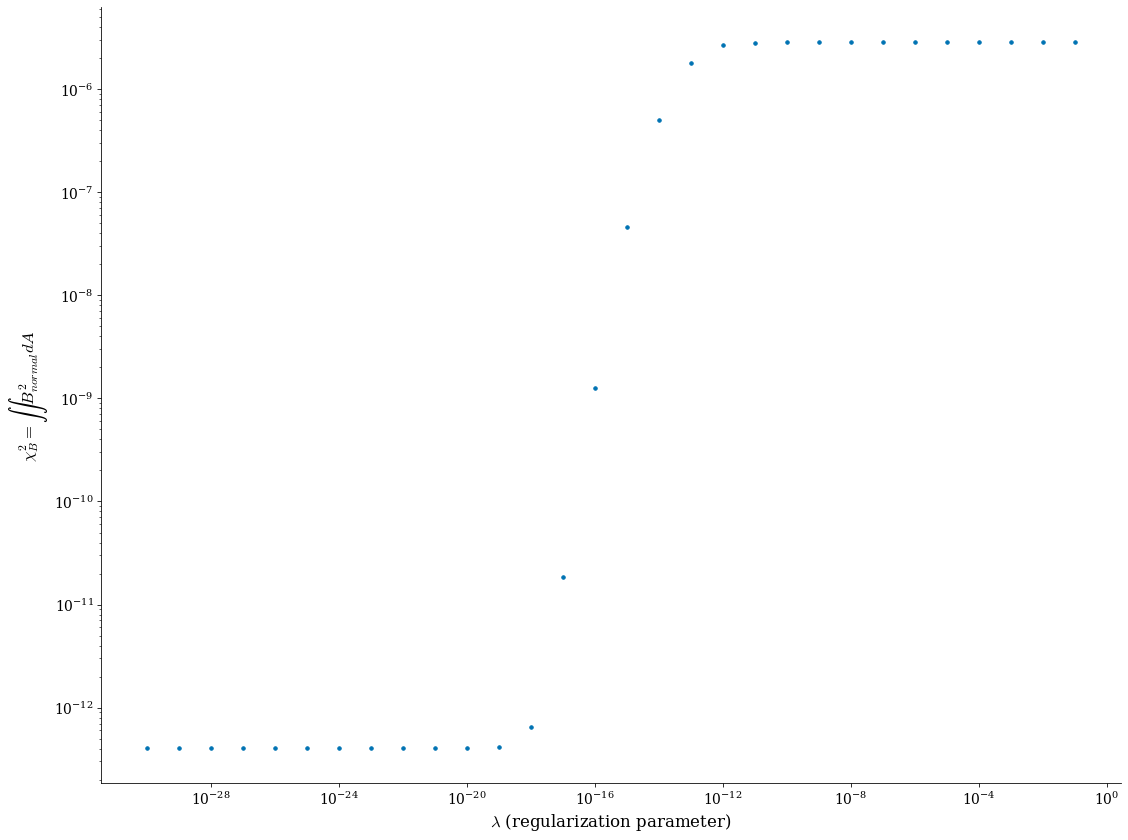

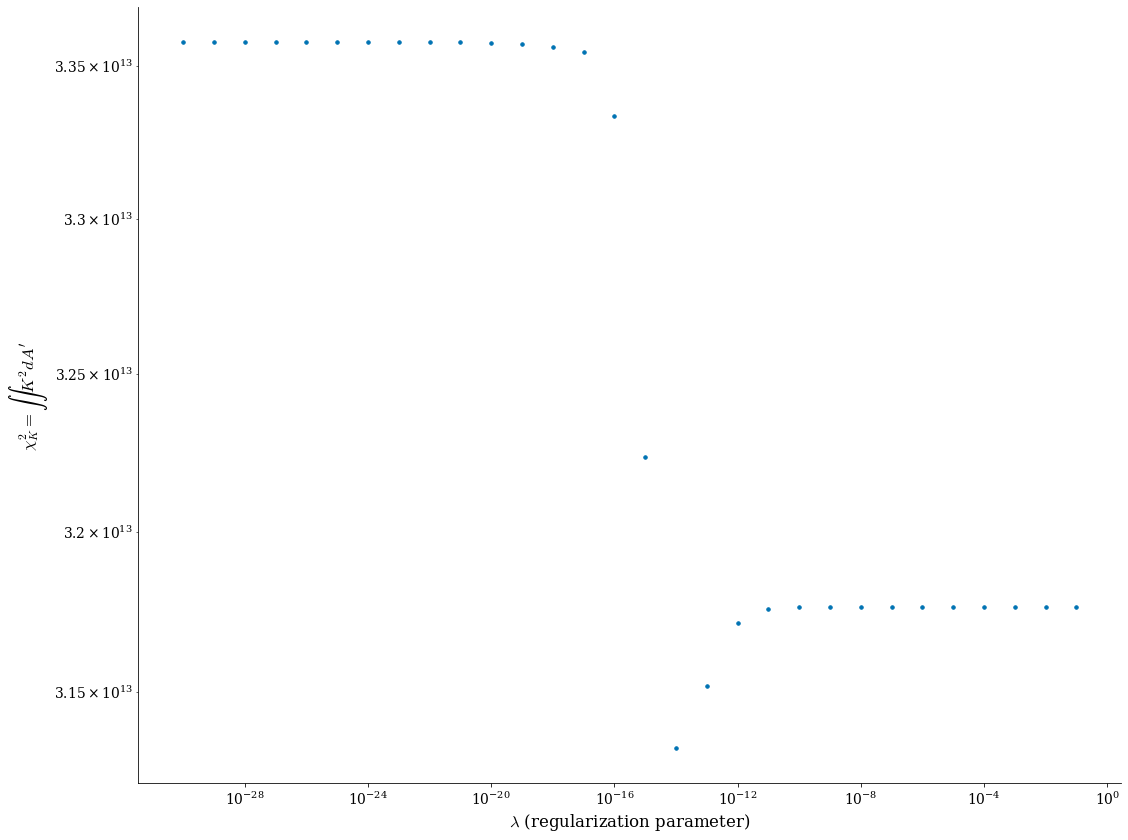

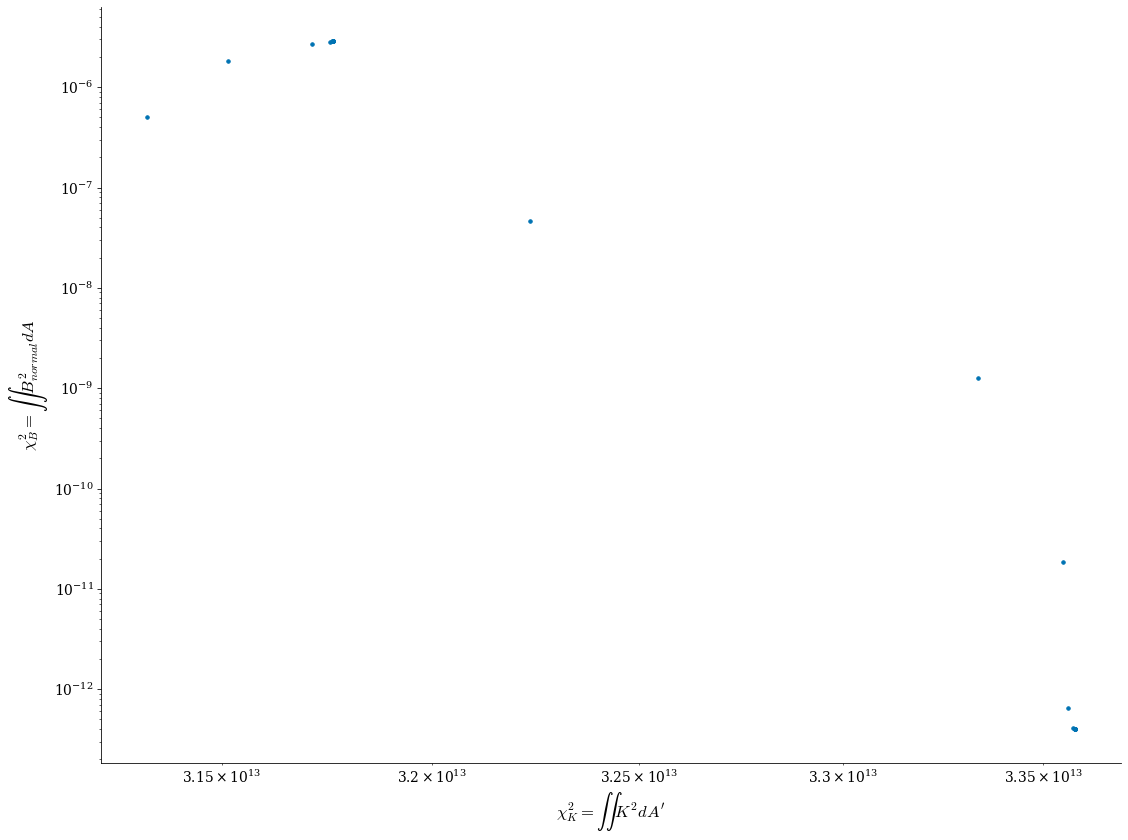

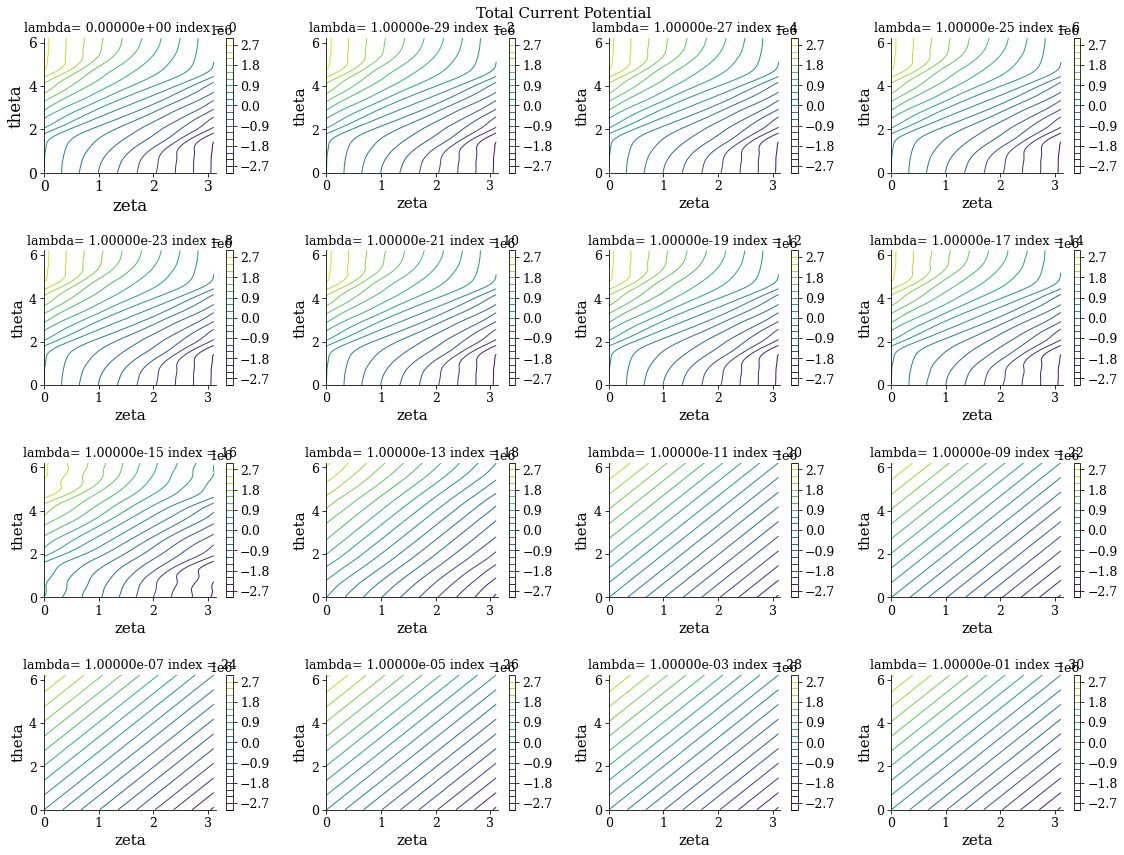

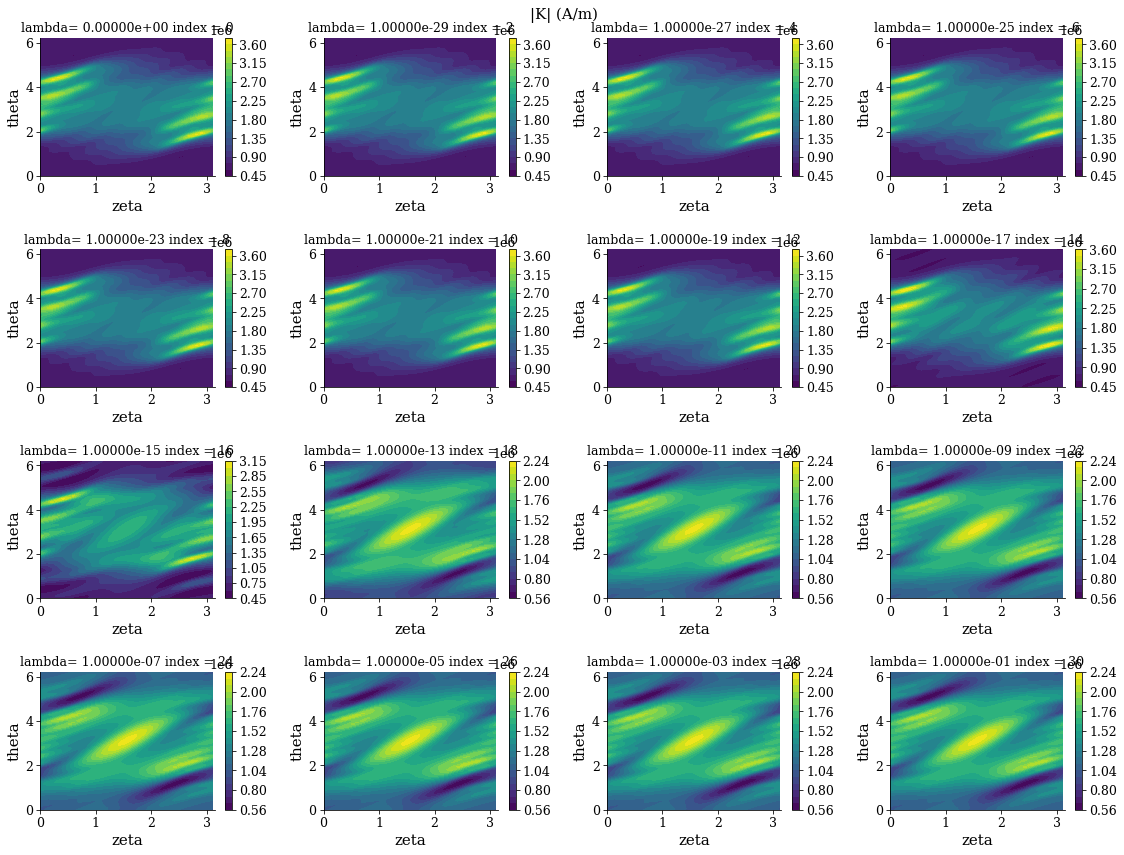

In [7]:
# create the FourierCurrentPotentialField object from the constant offset surface we found in the previous cell
surface_current_field_helical = FourierCurrentPotentialField.from_surface(surf,
                                                                  I=0, # this will be overwritten with the `run_regcoil` call
                                                                  # manually setting G to value needed to provide the equilibrium's toroidal flux
                                                                  G=np.asarray([-eq.compute("G", grid=LinearGrid(rho=np.array(1.0)))["G"][0] / mu_0 * 2 * np.pi]), 
                                                                  # set symmetry of the current potential, "sin" is usually expected for stellarator-symmetric surfaces and equilibria
                                                                  sym_Phi="sin",)
# we use the same grids from the above cells
surface_current_field_helical.change_Phi_resolution(M=8,N=8)

# run_regcoil method runs the REGCOIL algorithm
fields_helical,data_helical = run_regcoil(surface_current_field_helical, # the surface current field whose geometry and Phi resolution will be used
                                        eq=eq, # the Equilibrium object to minimize Bn on the surface of
                                         source_grid=sgrid, # source grid
                                         eval_grid=eval_grid, # evaluation grid
                                         current_helicity=(1,-1), # pair of integers (q,p), determines topology of contours (similar to QS helicity),
                                         #  q is the poloidal frequency of the transits per field period (the number of times the coil transits poloidally over a single field period)
                                         # and p is the toroidal analog (if q!=0 and p=0, we have modular coils, if both q and p are nonzero, we have helical coils)
                                         lambda_regularization=lambda_regularization, # we pass in an array to perform scan over the regularization parameter (which we call lambda_regularization) to see tradeoff between Bn and current complexity
                                         # lambda_regularization can also be just a single number in which case no scan is performed
                                         vacuum=True, # this is a vacuum equilibrium, so no need to calculate the Bn contribution from the plasma currents
                                         )
surface_current_field_helical = fields_helical[0]
plot_regcoil_outputs(surface_current_field_helical, data_helical, eq,vacuum=True)

From both of the above calculations, we can see that there is an optimal tradeoff between complexity and normal field error to be roughly $\lambda_regularization=1e-20$, so we will set the `surface_current_field` objects with the corresponding `Phi_mn`

In [8]:
# index 11 corresponds to lambda_regularization=~1e-20
surface_current_field.Phi_mn = data["Phi_mn"][11]
surface_current_field_helical.Phi_mn = data_helical["Phi_mn"][11]


## REGCOIL Algorithm with `QuadraticFlux`  and `SurfaceCurrentRegularization` Objective Functions

Alternatively, we can effectively do the same thing using the optimization framework of DESC, by using two objectives, a `QuadraticFlux` objective targeting the normal field errors on the plasma surface from the field, and a `SurfaceCurrentRegularization` objective to add the regularization based off of the surface current magnitude. This is basically the same problem as is solved above, but in a way that could be combined with other optimization objectives.

In [9]:
# form the constraints for the problem, we only want the Phi_mn to vary so we will fix all other parameters of FourierCurrentPotentialField
constraints = (# now fix all but Phi_mn
    FixParameters(surface_current_field,params={"I":True,"G":True,"R_lmn":True,"Z_lmn":True}),
)

Megrid=20
Negrid=20
Msgrid=40
Nsgrid=40
eval_grid=LinearGrid(M=Megrid,N=Negrid,NFP=eq.NFP,sym=True)
sgrid=LinearGrid(
                M=Msgrid,
                N=Nsgrid,
                NFP=eq.NFP,
            )
# we form the QuadraticFlux part of the objective function
obj_flux = QuadraticFlux(field=surface_current_field, # the field to be optimized
                         eq=eq,# the equilibrium upon which the quadratic flux is being evaluated
                         eval_grid=eval_grid,
                         source_grid = sgrid,
                         vacuum=True)
# the regularization cost based off of the surface current magnitude
obj_regularization = SurfaceCurrentRegularization(surface_current_field=surface_current_field,
                                                  source_grid = sgrid,
                                                   weight=np.sqrt(1e-20))# we will set it to the sqrt of optimal weight from above, since DESC will square the weight when making the overall cost fxn



optimizer = Optimizer("lsq-exact")

objective = ObjectiveFunction((obj_flux, obj_regularization))
(surface_current_field,), result = optimizer.optimize(
    surface_current_field, objective, constraints, verbose=1,
    ftol=0,
    gtol=0,
    xtol=1e-16,
    # because it is a linear least-squares problem, it is exactly solvable in 1 iteration
    maxiter=1,
    # we must make sure that the trust region of the optimization algorithm is
    # large enough to allow the entire problem to be solved in one step, so set the
    # trust radius to be infinite
    options={"initial_trust_radius":np.inf},
)


Building objective: Quadratic flux
Precomputing transforms
Building objective: surface-current-regularization
Precomputing transforms
Building objective: fixed parameters
Number of parameters: 312
Number of objectives: 7422
Starting optimization
Using method: lsq-exact
         Current function value: 8.940e-06
         Total delta_x: 3.600e+00
         Iterations: 1
         Function evaluations: 3
         Jacobian evaluations: 2
Start of solver
Total (sum of squares):  8.940e-06, 
Maximum absolute Boundary normal field error:  3.697e-06 (T m^2)
Minimum absolute Boundary normal field error:  1.905e-10 (T m^2)
Average absolute Boundary normal field error:  6.931e-07 (T m^2)
Maximum absolute Boundary normal field error:  2.333e-05 (normalized)
Minimum absolute Boundary normal field error:  1.202e-09 (normalized)
Average absolute Boundary normal field error:  4.374e-06 (normalized)
Maximum absolute Surface Current Regularization:  2.573e+06 A/m
Minimum absolute Surface Current Regulariz

(<Figure size 432.324x432.324 with 2 Axes>,
 <Axes: title={'center': '$\\Phi~(A)$'}, xlabel='$\\zeta$', ylabel='$\\theta$'>)

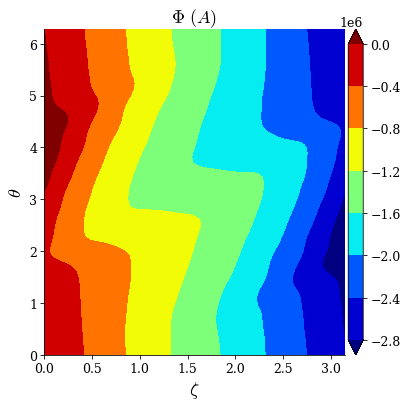

In [10]:
import matplotlib.pyplot as plt

plot_2d(eq.surface, "B*n",field=surface_current_field,field_grid=LinearGrid(M=80,N=80,NFP=eq.NFP),cmap="viridis")

plot_2d(surface_current_field, "Phi",levels=10)


## Create Coils from Surface Current

Now that we have the surface current, we can take a selection of constant $\Phi$ contours to discretize the surface current into coils. This can be done easily via the `FourierCurrentPotentialField.to_CoilSet` method, which will take the surface current field and return a discretized coilset with the desired total number of coils `num_coils`.

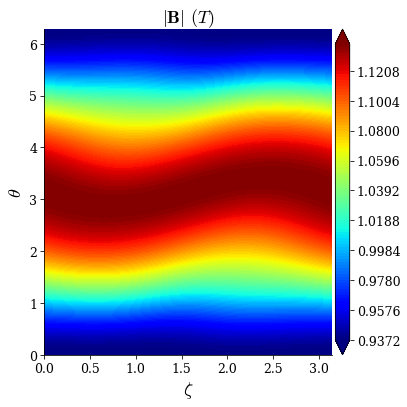

In [11]:
# for reference when we look at B normal errors we will plot the equilibrium magnetic field, it is roughly 1 T
plot_2d(eq,"|B|");

### Modular

In [12]:
coilset = surface_current_field.to_CoilSet(num_coils=12)
# num_coils is the number of coils per field period when the surface current helicity is zero, so we
# will get 12*NFP = 24 coils total

We can compute the normal field error with the coilset now, we see it has increased from before since there is some discretization error from representing the continuous surface current with a discrete number of coils. Typically an average normal field error of about 1 percent (when normalized by the equilibrium field strength) is desired, and this coilset still achieves that target field error.

Bn calc took 4.209e+00 seconds
normalized average <Bn> = 0.0035260804230745663


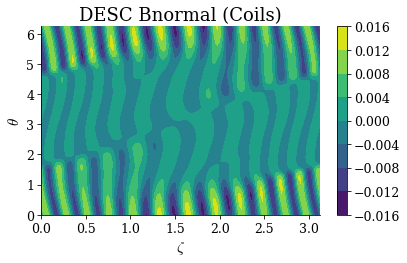

In [13]:
import time
t1=time.time()
grid = LinearGrid(M=80,N=80,NFP=eq.NFP)
Bn,_=coilset.compute_Bnormal(eq.surface,eval_grid=grid)
print(f"Bn calc took {time.time()-t1:1.3e} seconds")
plt.figure()
plt.contourf(grid.nodes[grid.unique_zeta_idx,2],grid.nodes[grid.unique_theta_idx,1],Bn.reshape((grid.num_zeta, grid.num_theta)).T)
plt.title("DESC Bnormal (Coils)")
plt.xlabel(r"$\zeta$")
plt.ylabel(r"$\theta$")

plt.colorbar()

print(f"normalized average <Bn> = {np.mean(np.abs(Bn) / eq.compute('|B|',grid=grid)['|B|'])}")

Bn calc took 1.413e+00 seconds
normalized average <Bn> = 0.003526602310910981


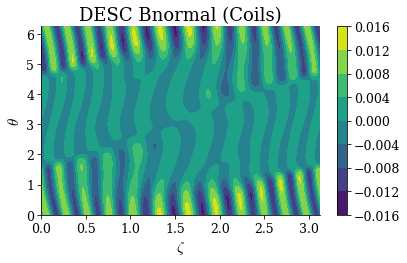

In [14]:
import time
grid = LinearGrid(M=80,N=80,NFP=eq.NFP)
coilset=coilset.to_FourierXYZ(N=50) # converting to a Fourier series will make the calculations more efficient
t1=time.time()
Bn,_=coilset.compute_Bnormal(eq.surface,eval_grid=grid)
print(f"Bn calc took {time.time()-t1:1.3e} seconds")
plt.figure()
plt.contourf(grid.nodes[grid.unique_zeta_idx,2],grid.nodes[grid.unique_theta_idx,1],Bn.reshape((grid.num_zeta, grid.num_theta)).T)
plt.title("DESC Bnormal (Coils)")
plt.xlabel(r"$\zeta$")
plt.ylabel(r"$\theta$")

plt.colorbar()

print(f"normalized average <Bn> = {np.mean(np.abs(Bn) / eq.compute('|B|',grid=grid)['|B|'])}")

(<Figure size 864.648x720.54 with 6 Axes>,
 array([<Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.000$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.167$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.333$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.500$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.667$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.833$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>],
       dtype=object))

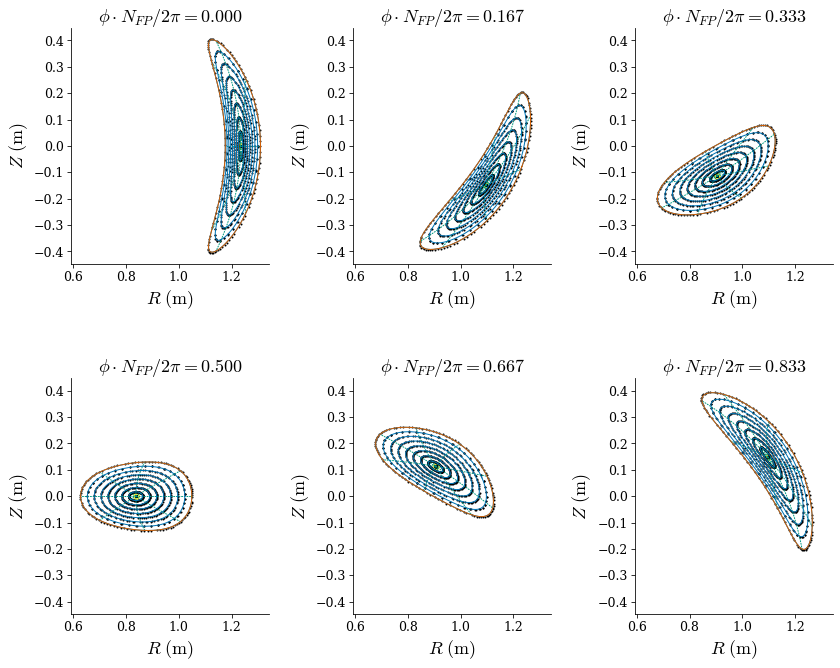

In [15]:
# Field line integration (on a CPU this can take a few minutes)
plot_field_lines(coilset, eq)

In [16]:
# visualize by plotting coils
fig = plot_3d(eq,"B*n",grid=LinearGrid(M=40,N=30,endpoint=True),field=coilset)
fig=plot_coils(coilset,fig=fig)
fig.show()

### Helical

Helical coil cutting is just as easy as modular, with the same exact function call:

In [17]:
coilset_helical = surface_current_field_helical.to_CoilSet(num_coils=16) 
# num_coils is the total number of coils when the surface current helicity is nonzero, so we
# will get 16 coils total

Bn calc took 7.005e+00 seconds
normalized average <Bn> = 0.0004791432509597228


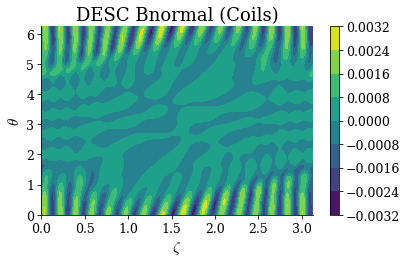

In [18]:
import time
t1=time.time()
Bn,_=coilset_helical.compute_Bnormal(eq.surface,eval_grid=grid)
print(f"Bn calc took {time.time()-t1:1.3e} seconds")
plt.figure()
plt.contourf(grid.nodes[grid.unique_zeta_idx,2],grid.nodes[grid.unique_theta_idx,1],Bn.reshape((grid.num_zeta, grid.num_theta)).T)
plt.title("DESC Bnormal (Coils)")
plt.xlabel(r"$\zeta$")
plt.ylabel(r"$\theta$")

plt.colorbar()
print(f"normalized average <Bn> = {np.mean(np.abs(Bn) / eq.compute('|B|',grid=grid)['|B|'])}")

Bn calc took 4.974e-01 seconds
normalized average <Bn> = 0.00048264589997514386


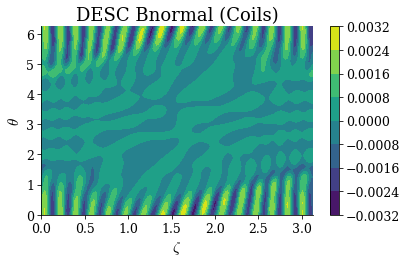

In [19]:
import time
coilset_helical = coilset_helical.to_FourierXYZ(N=35)
t1=time.time()
Bn,_=coilset_helical.compute_Bnormal(eq.surface,eval_grid=grid)
print(f"Bn calc took {time.time()-t1:1.3e} seconds")
plt.figure()
plt.contourf(grid.nodes[grid.unique_zeta_idx,2],grid.nodes[grid.unique_theta_idx,1],Bn.reshape((grid.num_zeta, grid.num_theta)).T)
plt.title("DESC Bnormal (Coils)")
plt.xlabel(r"$\zeta$")
plt.ylabel(r"$\theta$")

plt.colorbar()
print(f"normalized average <Bn> = {np.mean(np.abs(Bn) / eq.compute('|B|',grid=grid)['|B|'])}")

In [20]:
# Field line integration (on a CPU this can take a few minutes)
plot_field_lines(coilset_helical, eq)

(<Figure size 864.648x720.54 with 6 Axes>,
 array([<Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.000$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.167$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.333$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.500$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.667$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.833$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>],
       dtype=object))

In [21]:
# visualize by plotting coils
fig = plot_3d(eq,"B*n",grid=LinearGrid(M=40,N=30,endpoint=True),field=coilset_helical)

fig=plot_coils(coilset_helical,fig=fig)
fig.show()

These coils can then be used as the initial guesses for a filamentary coil optimization (see the tutorial on stage two filamentery coil optimization!) to refine the solution and reduce the Bn error further, as well as accounting for engineering tolerances. 